In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

from gob.benchmarks import *
from gob.optimizers import *
import matplotlib
matplotlib.rcParams.update({"text.usetex": True})

In [2]:
class MinWrapper:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
  
  def __call__(self, x):
    y = self.func(x)
    self.values.append(y)
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles + 1):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

class MinWrapperGrad:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
    self.prev_sample = None
  
  def __call__(self, x):
    y = self.func(x)
    if self.prev_sample is None or not np.all(np.abs(x - self.prev_sample) <= 2e-9):
      self.values.append(y)
    self.prev_sample = x
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

In [ ]:
def format_results(res):
  for i in range(len(res)):
    if len(res[i]) < iter:
      print(f"Run {i} of mins_m1 has length {len(res[i])} instead of {iter}")
      # Copy the last value to extend the length
      last_value = res[i][-1]
      res[i] = list(res[i]) + [last_value] * (iter - len(res[i]))

In [3]:
g = Ackley()
dim = 8
bounds = augment_dimensions(g.visual_bounds, dim)
n_particles = 300
iter = 1000
verbose = False
n_runs = 5
wrapper = MinWrapperGrad
alg = Langevin
cn_alg = CN_Langevin

In [ ]:
mins = []
for i in range(n_runs):
  f = wrapper(g)

  opt = alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose)
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins)
mins = np.array(mins)

Results for Langevin: 6.591138805510937
Results for Langevin: 7.635565316669144
Results for Langevin: 7.490713504694559
Results for Langevin: 8.364375992720014
Results for Langevin: 7.0783461938599395


In [ ]:
mins_m1 = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="M1")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_m1.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_m1)
mins_m1 = np.array(mins_m1)

Results for CN-Langevin: 0.2504316747943993
Results for CN-Langevin: 0.1157137051196
Results for CN-Langevin: 0.27839538047662815
Results for CN-Langevin: 0.10596764407467463
Results for CN-Langevin: 0.10127901557521257
Run 0 of mins_m1 has length 903 instead of 1000
Run 1 of mins_m1 has length 893 instead of 1000
Run 2 of mins_m1 has length 918 instead of 1000
Run 3 of mins_m1 has length 920 instead of 1000
Run 4 of mins_m1 has length 936 instead of 1000


In [ ]:
mins_m2 = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="M2")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_m2.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_m2)
mins_m2 = np.array(mins_m2)

Results for CN-Langevin: 0.07021104514234056
Results for CN-Langevin: 0.13822549760416125
Results for CN-Langevin: 0.09694481294589297
Results for CN-Langevin: 0.08276801815930002
Results for CN-Langevin: 0.07518952101520116


In [ ]:
mins_var = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="VAR")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_var.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_var)
mins_var = np.array(mins_var)

Results for CN-Langevin: 0.1292764926871226
Results for CN-Langevin: 0.07128286870686695
Results for CN-Langevin: 0.09870889828315699
Results for CN-Langevin: 0.13935210642889162
Results for CN-Langevin: 0.07928995198352995


In [ ]:
mins_mvar = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="MVAR")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_mvar.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_mvar)
mins_mvar = np.array(mins_mvar)

Results for CN-Langevin: 8.990010297537005
Results for CN-Langevin: 8.216896966894229
Results for CN-Langevin: 8.470401855460848
Results for CN-Langevin: 8.106568314355924
Results for CN-Langevin: 7.0124932576791


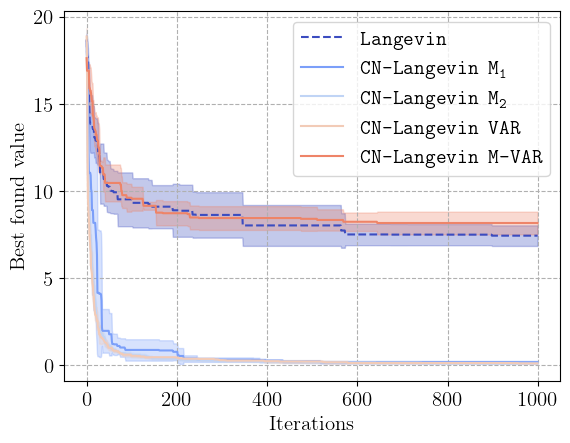

In [9]:
alg_name = str(alg([]))
cn_alg_name = str(cn_alg([]))

latex_label = lambda s: r"\texttt{" + s.replace("_", r"\_") + "}"

cmap = matplotlib.colormaps["coolwarm"]

c0 = cmap(0)
c1 = cmap(0.2)
c2 = cmap(0.4)
c3 = cmap(0.6)
c4 = cmap(0.8)

plt.rcParams.update({"font.size": 15})

mean = mins.mean(axis=0)
std = mins.std(axis=0)
plt.plot(mean, label=latex_label(alg_name), linestyle="--", color=c0)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c0)

mean = mins_m1.mean(axis=0)
std = mins_m1.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{1}"), linestyle="-", c=c1)
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.3, color=c1)

mean = mins_m2.mean(axis=0)
std = mins_m2.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{2}"), linestyle="-", c=c2)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c2)

mean = mins_var.mean(axis=0)
std = mins_var.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} VAR"), linestyle="-", c=c3)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c3)

mean = mins_mvar.mean(axis=0)
std = mins_mvar.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M-VAR"), linestyle="-", c=c4)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c4)

plt.xlabel(r"$\textrm{Iterations}$")
plt.ylabel(r"$\textrm{Best found value}$")
plt.grid(linestyle="--")
plt.legend()
plt.savefig(f"impact_noise_{alg_name.lower()}.pdf", bbox_inches="tight")